# Lecture : Graph Generation Models

## Lab 03 : WGAN model for mixture of Gaussians

### Xavier Bresson, Nian Liu


In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2024_codes/codes/11_Graph_Generation'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    

In [2]:
# Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import time
#import utils
import matplotlib.pyplot as plt
import logging
logging.getLogger().setLevel(logging.CRITICAL) # remove warnings
import os, datetime

# PyTorch version and GPU
print(torch.__version__)
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))
  device= torch.device("cuda:0") # use GPU
else:
  device= torch.device("cpu")
print(device)


2.1.2
NVIDIA GeForce RTX 4090 Laptop GPU
cuda:0


# Create artifical dataset of mixture of Gaussians

num_x, range_x, step_x, x :  100 20 0.40404040404040403 torch.Size([100])
num_gaussians :  2
train_data, bs, num_batch :  torch.Size([4000, 100]) 100 40
train_data :  torch.Size([4000, 100])
max, min, mean :  tensor(1.) tensor(-1.) tensor(-0.7510)


<Figure size 640x480 with 0 Axes>

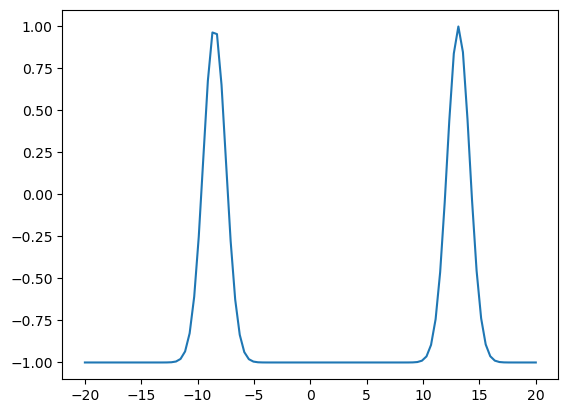

<Figure size 640x480 with 0 Axes>

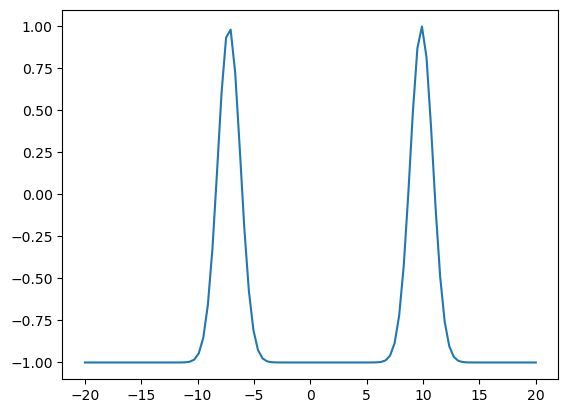

In [3]:
# Parameters of the mixture of Gaussians
num_data = 4000
num_x = 100
range_x = 20
step_x = 2 * range_x / (num_x - 1)
x = torch.arange(-range_x,range_x+step_x,step_x)
print('num_x, range_x, step_x, x : ',num_x, range_x, step_x, x.size())
num_gaussians = 2
print('num_gaussians : ', num_gaussians)
train_data = torch.zeros(num_data, num_x)
bs = 100
num_batch = num_data//bs
print('train_data, bs, num_batch : ', train_data.size(), bs, num_batch)

for k in range(num_batch):
    mu = torch.zeros(num_gaussians, bs)
    mu[0,:] = torch.FloatTensor(bs).uniform_(-15, -5)
    mu[1,:] = torch.FloatTensor(bs).uniform_(5, 15)   
    mu_batch = mu.unsqueeze(2)
    sigma = torch.ones(num_gaussians, bs)
    sigma_batch = sigma.unsqueeze(2)
    x_batch = x.repeat(num_gaussians, bs, 1)
    p = torch.exp( - (x_batch - mu_batch)**2 / (2* sigma_batch**2) ) / torch.sqrt( 2* torch.pi* sigma_batch**2 )
    p = p.sum(0); p /= p.sum(1).unsqueeze(1)
    p = ( p - p.min(1)[0].unsqueeze(1) ) / ( p.max(1)[0].unsqueeze(1) - p.min(1)[0].unsqueeze(1) )
    p = 2 * ( p - 0.5 )
    train_data[k*bs:(k+1)*bs, :] = p
print('train_data : ',train_data.size())
print('max, min, mean : ',train_data.max(), train_data.min(), train_data.mean())

plt.figure(2)
plt.figure(dpi=100)
plt.plot(x, train_data[0])
plt.show()
plt.figure(3)
plt.figure(dpi=100)
plt.plot(x, train_data[1])
plt.show()


# Design the class of WGAN model [1,2,3] with Transformers [4] 

[1] Goodfellow et-al, Generative Adversarial Networks, 2014, https://arxiv.org/pdf/1406.2661  
[2] Arjovsky et-al, Wasserstein GAN, 2017, https://arxiv.org/pdf/1701.07875  
[3] Gulrajani et-al, Improved Training of Wasserstein GANs, 2017, https://arxiv.org/pdf/1704.00028  
[4] Vaswani et-al, Attention Is All You Need, 2017, https://arxiv.org/pdf/1706.03762    



In [4]:
# Global constants
N = train_data.size(0) # number of training data
n = train_data.size(1) # number of elements in the line 
print('N, n : ', N, n)

dz = 16 # number of dimensions for the compressed representation
num_heads = 4 # number of heads in the transformer layer
d = 32 * num_heads # number of hidden dimensions
num_layers_discriminator = 2 # number of transformer discriminator layers
num_layers_generator = 2 # number of transformer generator layers
drop = 0.0 # dropout value
dropout_dis = 0.05 # dropout value for the discriminator network
bs = 50 # batch size
print('dz, num_heads, d, num_layers_discriminator, num_layers_generator, drop, dropout_dis, bs : ', \
      dz, num_heads, d, num_layers_discriminator, num_layers_generator, drop, dropout_dis, bs)


N, n :  4000 100
dz, num_heads, d, num_layers_discriminator, num_layers_generator, drop, dropout_dis, bs :  16 4 128 2 2 0.0 0.05 50


In [5]:
# Define WGAN architecture with Transformers
class head_attention(nn.Module):
    def __init__(self, d, d_head):
        super().__init__()
        self.Q = nn.Linear(d, d_head)
        self.K = nn.Linear(d, d_head)
        self.V = nn.Linear(d, d_head)
        self.sqrt_d = torch.sqrt(torch.tensor(d_head))
        self.drop_att = nn.Dropout(drop)
    def forward(self, x):
        Q = self.Q(x)      # [bs, n, d_head]
        K = self.K(x)      # [bs, n, d_head]
        V = self.V(x)      # [bs, n, d_head]
        Q = Q.unsqueeze(2) # [bs, n, 1, d_head]
        K = K.unsqueeze(1) # [bs, 1, n, d_head]
        Att = (Q * K).sum(dim=3) / self.sqrt_d # [bs, n, n]
        Att = torch.softmax(Att, dim=1)        # [bs, n, n]
        Att = self.drop_att(Att) # [bs, n, d_head]
        x = Att @ V              # [bs, n, d_head]
        return x

class MHA(nn.Module):
    def __init__(self, d, num_heads):  
        super().__init__()
        d_head = d // num_heads
        self.heads = nn.ModuleList( [head_attention(d, d_head) for _ in range(num_heads)] )
        self.WOx = nn.Linear(d, d)
        self.drop_x = nn.Dropout(drop)
    def forward(self, x):
        x_MHA = []  
        for head in self.heads:
            x_HA = head(x)     # [bs, n, d_head]
            x_MHA.append(x_HA)
        x = self.WOx(torch.cat(x_MHA, dim=2)) # [bs, n, d]
        x = self.drop_x(x)                    # [bs, n, d]
        return x

class BlockGT(nn.Module):
    def __init__(self, d, num_heads):  
        super().__init__()
        self.LNx = nn.LayerNorm(d)
        self.LNx2 = nn.LayerNorm(d)
        self.MHA = MHA(d, num_heads)
        self.MLPx = nn.Sequential(nn.Linear(d, 4*d), nn.LeakyReLU(), nn.Linear(4*d, d))
        self.drop_x_mlp = nn.Dropout(drop)
        self.mu = nn.Linear(d, d, bias=True)
    def forward(self, x):
        x_in = x                        # [bs, n, d]
        x = self.LNx(x)                 # [bs, n, d]
        x_MHA = self.MHA(x)             # [bs, n, d]
        x = x_in + x_MHA                # [bs, n, d]
        x = x + self.MLPx(self.LNx2(x)) # [bs, n, d]
        x = self.drop_x_mlp(x)          # [bs, n, d]
        return x

# Question 1: Implement the WGAN architecture

#### Step 1: Construct the generator
- Build the generator network using `BlockGT`.
- Map noise `z` into features for each data point.
- Go through the generator network.
- Map the output data embedding into the generated data. \
Notice the usage of `LayerNorm`.

#### Step 2: Define the discriminator
- Build the discriminator network using `BlockGT`.
- Go through the discriminator network.
- According to all output data embeddings, predict the discriminator value of the given input sample. \

Notices:
- The number of layers of generator and discriminator can be the same.
- The dropout layer is used after each layer of the discriminator.

#### Step 3: Design WGAN
Initialize the generator and the discriminator, and code their forward process.


In [6]:
class generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_z = nn.Linear(dz, n*d)
        self.ln_h = nn.LayerNorm(n*d)
        ###############################################
        # Initialize generator network
        # YOUR CODE STARTS
        ###############################################
        self.gt_gen_layers = nn.ModuleList( [BlockGT(d, num_heads) for k in range(num_layers_generator)] )  
        ###############################################
        # YOUR CODE ENDS
        ###############################################
        self.ln_final = nn.LayerNorm(d)  
        self.linear_final = nn.Linear(d, 1)
    def forward(self, z, pe):  
        # input layer
        ###############################################
        # noise z -> initial features for data points
        # YOUR CODE STARTS
        ###############################################
        h = self.linear_z(z) # [bs, n*d] 
        ###############################################
        # YOUR CODE ENDS
        ###############################################
        h = self.ln_h(h) # [bs, n*d] 
        h = nn.LeakyReLU()(h) # [bs, n*d] 
        bs2 = h.size(0)
        h = h.view(bs2, n, d) # [bs, n, d]
        h = h + pe[:bs2,:,:] # [bs, n, d]
        ###############################################
        # Go through generator
        # YOUR CODE STARTS
        ###############################################
        # L layers
        for gt_gen_layer in self.gt_gen_layers:
            h = gt_gen_layer(h) # [bs, n, d]
        ###############################################
        # YOUR CODE ENDS
        ###############################################
        # output    
        h = nn.LeakyReLU()(h) # [bs, n, d] 
        h = self.ln_final(h) # [bs, n, d] 
        ###############################################
        # embedding h -> generated data
        # YOUR CODE STARTS
        ###############################################
        h = self.linear_final(h).squeeze() # [bs, n] 
        ###############################################
        # YOUR CODE ENDS
        ###############################################
        return h

class discriminator(nn.Module):
    def __init__(self):
        super().__init__()   
        self.h_emb = nn.Linear(1, d)
        ###############################################
        # Initialize discriminator network and dropout layers
        # YOUR CODE STARTS
        ###############################################
        self.gt_dis_layers = nn.ModuleList( [BlockGT(d, num_heads) for k in range(num_layers_discriminator)] )  
        self.dp_dis_layers = nn.ModuleList( [nn.Dropout(p=dropout_dis) for k in range(num_layers_discriminator)] ) 
        ###############################################
        # YOUR CODE ENDS
        ############################################### 
        self.linear_out = nn.Linear(n*d, 1)   
    def forward(self, h, pe): 
        # input layer
        h = self.h_emb(h.unsqueeze(2)) # [bs, n, d]
        h = h + pe                     # [bs, n, d] 
        ###############################################
        # Go through discriminator
        # YOUR CODE STARTS
        ###############################################
        # L layers
        for gt_dis_layer, dp_dis_layer in zip(self.gt_dis_layers, self.dp_dis_layers): 
            h = gt_dis_layer(h)       # [bs, n, d]
            h = dp_dis_layer(h)        # [bs, n, d]
        ###############################################
        # YOUR CODE ENDS
        ############################################### 
        # output
        h = h.contiguous().view(bs, n*d) # [bs, n*d]
        ###############################################
        # Predict the truth of the input `h`
        # YOUR CODE STARTS
        ###############################################
        h = self.linear_out(h)         # [bs, 1]
        ###############################################
        # YOUR CODE ENDS
        ############################################### 
        return h

class WGAN(nn.Module):
    def __init__(self):
        super().__init__()
        self.pe_x = nn.Embedding(n, d)
        self.generator = generator()
        self.discriminator = discriminator()
    def forward_gen(self, z):
        pe = torch.arange(0,n).to(device).repeat(bs,1) # [bs, n] 
        pe = self.pe_x(pe) # [bs, n, d] 
        ###############################################
        # YOUR CODE STARTS
        ###############################################
        g_z = self.generator(z, pe)
        ###############################################
        # YOUR CODE ENDS
        ############################################### 
        return g_z
    def forward_dis(self, h):
        pe = torch.arange(0,n).to(device).repeat(bs,1) # [bs, n] 
        pe = self.pe_x(pe) # [bs, n, d] 
        ###############################################
        # YOUR CODE STARTS
        ###############################################
        d_h = self.discriminator(h, pe)
        ###############################################
        # YOUR CODE ENDS
        ############################################### 
        return d_h

# Question 2: Code the training pipeline of WGAN, including optimizer, loss, and backward pass

Hints:
- Separate the parameters from the generator and the discriminator, and set different optimizers for them.
- Training losses for the generator and the discriminator are as follows:
\begin{eqnarray*}
    &&\quad\quad\ \textrm{Discriminator Loss: } \mathbb{L}_D(\phi)=\mathbb{E}(D_\phi(x_{real}))-\mathbb{E}(D_\phi(x_{gen}))+\lambda(||\bigtriangledown_{\hat{x}}D_\phi(\hat{x})||_2-1)\\
&&\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\ \textrm{where } \hat{x}=\epsilon x_{real}+(1-\epsilon)x_{gen}, \epsilon\sim\mathcal{N}(0, I)\\
&&\quad\quad\ \textrm{Generator Loss: } \mathbb{L}_G(\theta)=-\mathbb{E}(D_\phi(x_{gen}))=-\mathbb{E}(D_\phi(G_\theta(z)))
\end{eqnarray*}

For the discriminator loss, use [torch.autograd.grad(outputs, inputs, grad_outputs, create_graph)](https://pytorch.org/docs/stable/generated/torch.autograd.grad.html) to get the gradient of `outputs` over `inputs`.   
`grad_outputs` lets you specify the gradient values at the output tensor to propagate backward.   
`create_graph=True` allows us to use the gradients as part of the loss.


In [ ]:
# Instantiate the network
net = WGAN()
net = net.to(device)
def display_num_param(net):
    nb_param = 0
    for param in net.parameters():
        nb_param += param.numel()
    print('Number of parameters: {} ({:.2f} million)'.format(nb_param, nb_param/1e6))
_ = display_num_param(net)

# Test the forward pass, backward pass and gradient update with a single batch
init_lr = 0.001
###############################################
# Separate parameters, define different optimizers
# YOUR CODE STARTS
###############################################
list_param = []
for p in net.generator.parameters():
    list_param.append(p)
for p in net.pe_x.parameters():
    list_param.append(p)
params_gen = nn.ParameterList(list_param)
list_param = []
for p in net.discriminator.parameters():
    list_param.append(p)
for p in net.pe_x.parameters():
    list_param.append(p)
params_dis = nn.ParameterList(list_param)
optimizer_g = torch.optim.Adam(params_gen, lr=init_lr)
optimizer_d = torch.optim.Adam(params_dis, lr=init_lr)
###############################################
# YOUR CODE ENDS
###############################################

idx_data = torch.LongTensor(bs).random_(0,N)
x_real = train_data[idx_data,:].to(device) # [bs, n]
print('x_real',x_real.size())
z = torch.rand(bs, dz).to(device) # [bs, dz]
print('z',z.size())

x_fake = net.forward_gen(z) # [bs, n]
print('x_fake',x_fake.size())
fake_discr = net.forward_dis(x_fake) # [bs, 1]    
real_discr = net.forward_dis(x_real) # [bs, 1]
print('fake_discr',fake_discr.size())
print('real_discr',real_discr.size())

###############################################
# Calculate discriminator loss, and back propagate
# YOUR CODE STARTS
###############################################
# For GAN loss, we use the mean 
# D_phi(x_real) - D_phi(x_gen)
loss = fake_discr.mean() - real_discr.mean()
# Calculate x_hat
epsilon = torch.FloatTensor(bs, 1).uniform_(0, 1).to(device)
x_hat = epsilon * x_fake + (1 - epsilon) * x_real
# D_phi(x_hat)
xhat_discr = net.forward_dis(x_hat)
# Gradients of D_phi(x_hat)
grads = torch.autograd.grad(xhat_discr, x_hat, grad_outputs=torch.ones_like(xhat_discr), create_graph=True)[0]
penalty = ((torch.sqrt((grads ** 2).sum(1)) - 1) ** 2).mean()
# Lambda = 10
loss = loss + 10 * penalty

optimizer_d.zero_grad()
loss.backward()
optimizer_d.step()
###############################################
# YOUR CODE ENDS
###############################################

z = torch.rand(bs, dz).to(device) # [bs, dz]
###############################################
# Calculate generator loss, and back propagate
# YOUR CODE STARTS
###############################################
# For GAN loss, we use the mean
# -E(D_phi(G_theta(z)))
loss = - net.forward_dis(net.forward_gen(z)).mean()
optimizer_g.zero_grad()
loss.backward()
optimizer_g.step()
###############################################
# YOUR CODE ENDS
###############################################

Number of parameters: 1128578 (1.13 million)
x_real torch.Size([50, 100])
z torch.Size([50, 16])
x_fake torch.Size([50, 100])
fake_discr torch.Size([50, 1])
real_discr torch.Size([50, 1])


Number of parameters: 1128578 (1.13 million)
dz, num_heads, d, num_layers_discriminator, num_layers_generator, drop, dropout_dis, bs :  16 4 128 2 2 0.0 0.05 50
epoch= 0    time= 0.2295 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.02887    loss_g= 0.39048
epoch= 1    time= 0.4570 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.02086    loss_g= 0.00106
epoch= 2    time= 0.6683 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.03134    loss_g= -2.7614
epoch= 3    time= 0.8876 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.03302    loss_g= -4.6323
epoch= 4    time= 1.1120 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.02069    loss_g= -6.3377
epoch= 5    time= 1.3269 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.02217    loss_g= -8.7784
epoch= 6    time= 1.5494 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00512    loss_g= -12.213
epoch= 7    time= 1.7670 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00630    loss_g= -14.752

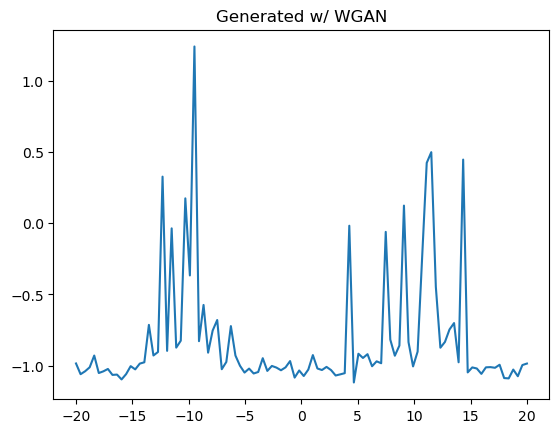

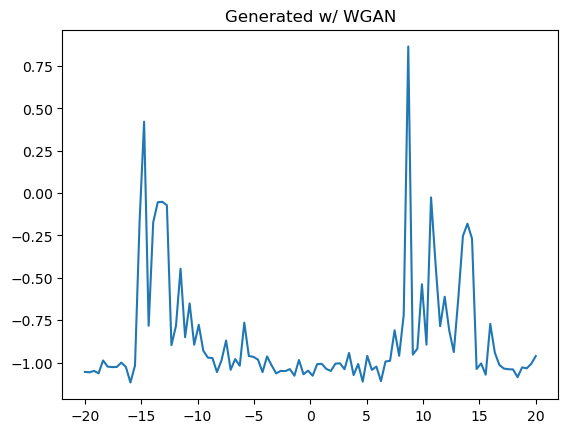

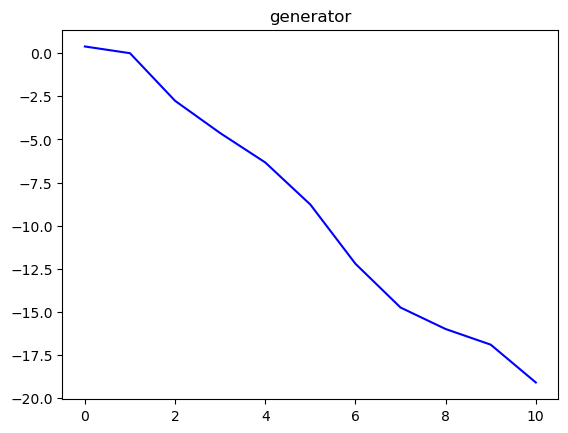

epoch= 11    time= 2.7241 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.02755    loss_g= -24.162
epoch= 12    time= 2.9528 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.02197    loss_g= -29.926
epoch= 13    time= 3.1766 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.02209    loss_g= -35.348
epoch= 14    time= 3.4172 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.02036    loss_g= -38.969
epoch= 15    time= 3.6507 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.01917    loss_g= -42.104
epoch= 16    time= 3.8800 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00884    loss_g= -44.813
epoch= 17    time= 4.1091 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.01948    loss_g= -48.251
epoch= 18    time= 4.3408 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.01179    loss_g= -52.616
epoch= 19    time= 4.5564 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.01026    loss_g= -56.926
epoch= 20    time= 4.7933 min    lr_d= 0.00030

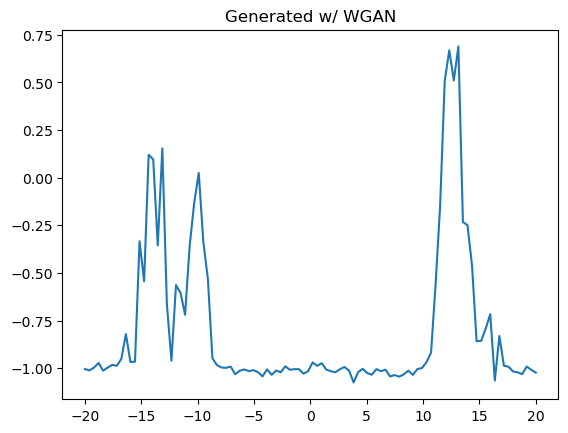

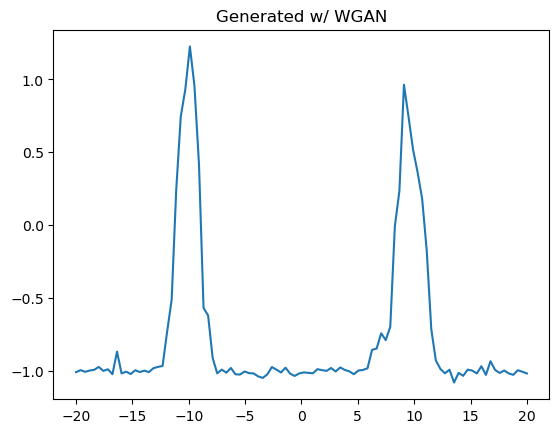

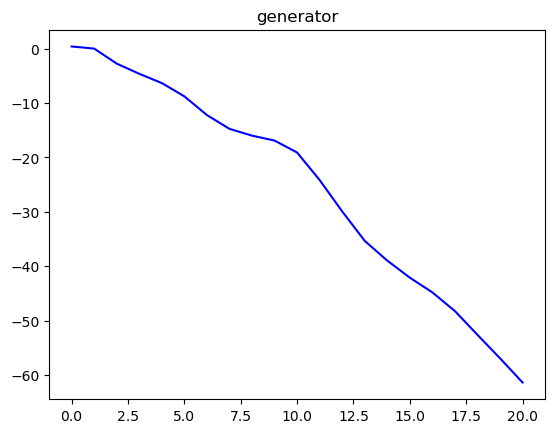

epoch= 21    time= 5.0188 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00653    loss_g= -66.600
epoch= 22    time= 5.2458 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.01042    loss_g= -70.050
epoch= 23    time= 5.4689 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00894    loss_g= -73.529
epoch= 24    time= 5.6959 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00208    loss_g= -78.637
epoch= 25    time= 5.9253 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.01276    loss_g= -83.134
epoch= 26    time= 6.1672 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00407    loss_g= -87.718
epoch= 27    time= 6.3815 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00462    loss_g= -91.603
epoch= 28    time= 6.5966 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0009    loss_g= -95.060
epoch= 29    time= 6.8045 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00385    loss_g= -97.502
epoch= 30    time= 7.0262 min    lr_d= 0.00030

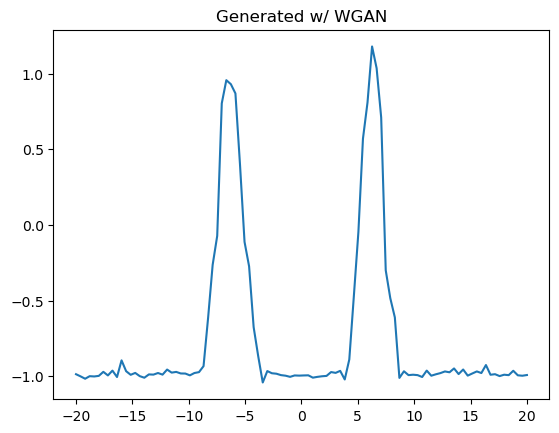

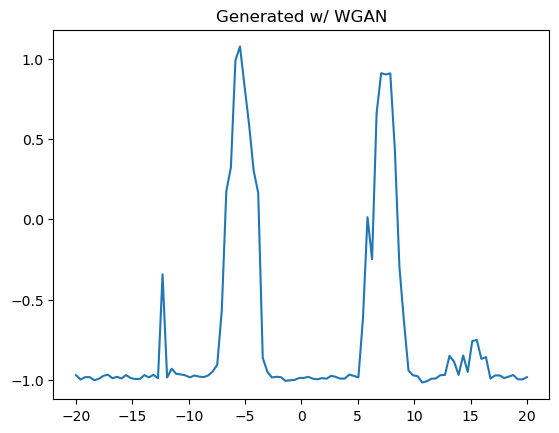

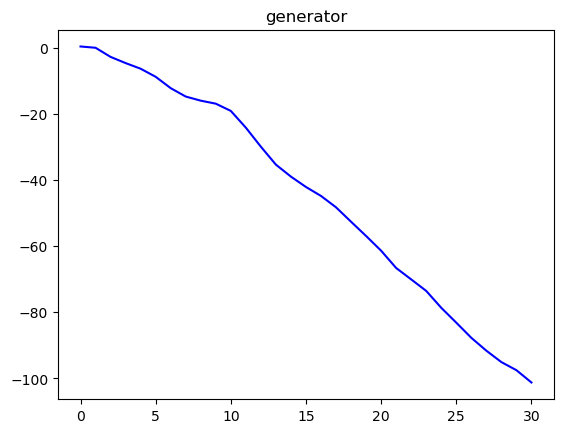

epoch= 31    time= 7.2453 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00773    loss_g= -106.08
epoch= 32    time= 7.4562 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00205    loss_g= -110.58
epoch= 33    time= 7.6780 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00025    loss_g= -114.41
epoch= 34    time= 7.9104 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00418    loss_g= -119.65
epoch= 35    time= 8.1338 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00772    loss_g= -123.70
epoch= 36    time= 8.3703 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00219    loss_g= -127.68
epoch= 37    time= 8.5902 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00052    loss_g= -129.85
epoch= 38    time= 8.8177 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0028    loss_g= -134.43
epoch= 39    time= 9.1656 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0042    loss_g= -137.34
epoch= 40    time= 9.5023 min    lr_d= 0.00030

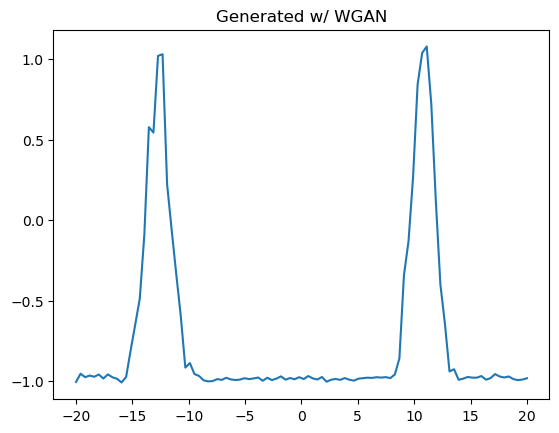

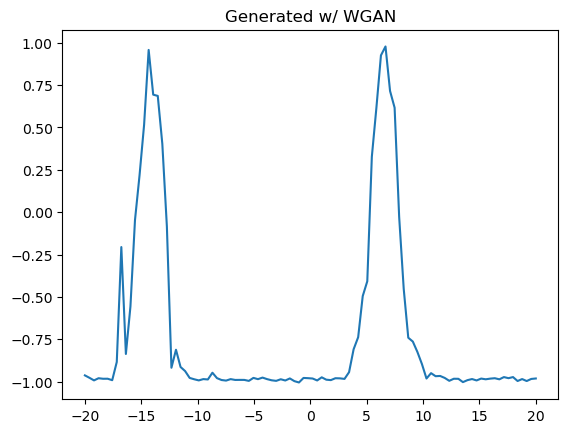

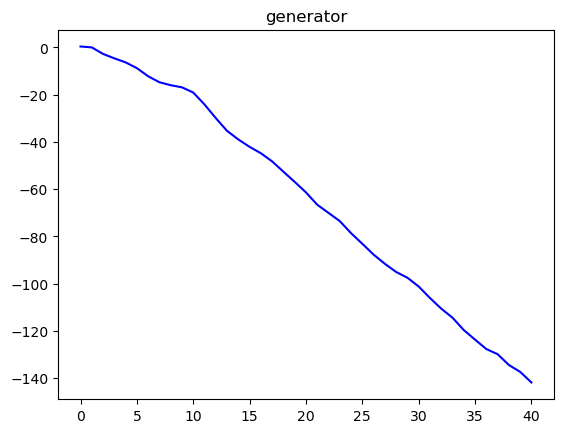

epoch= 41    time= 9.8504 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0010    loss_g= -146.04
epoch= 42    time= 10.209 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0008    loss_g= -150.39
epoch= 43    time= 10.596 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00037    loss_g= -154.68
epoch= 44    time= 10.949 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0020    loss_g= -157.76
epoch= 45    time= 11.324 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00557    loss_g= -163.48
epoch= 46    time= 11.688 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0016    loss_g= -168.89
epoch= 47    time= 12.043 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0067    loss_g= -172.90
epoch= 48    time= 12.381 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00092    loss_g= -178.27
epoch= 49    time= 12.724 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00328    loss_g= -184.57
epoch= 50    time= 13.064 min    lr_d= 0.00030

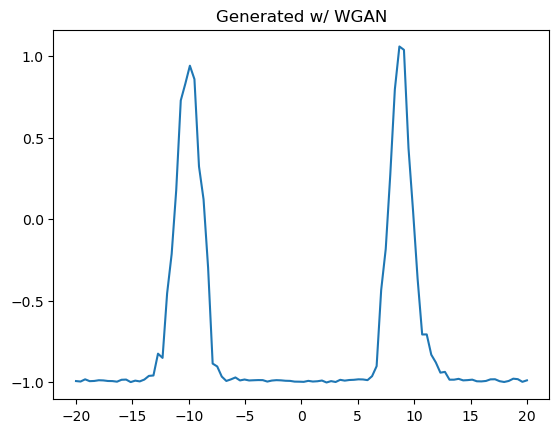

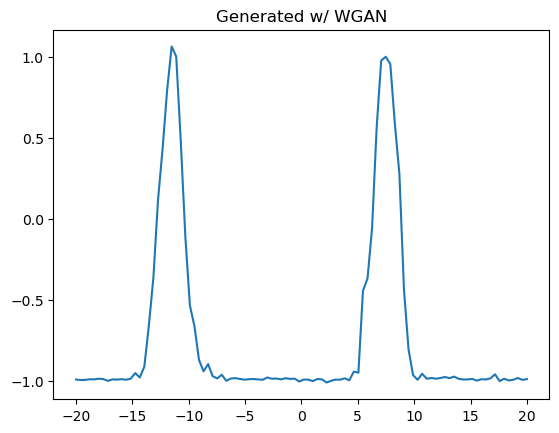

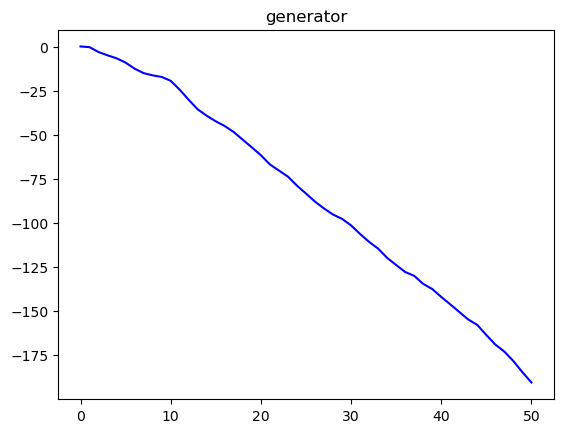

epoch= 51    time= 13.446 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00307    loss_g= -195.57
epoch= 52    time= 13.783 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00161    loss_g= -198.63
epoch= 53    time= 14.131 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00744    loss_g= -202.44
epoch= 54    time= 14.485 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -8.7409    loss_g= -207.03
epoch= 55    time= 14.849 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0016    loss_g= -210.62
epoch= 56    time= 15.201 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00623    loss_g= -215.17
epoch= 57    time= 15.543 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00336    loss_g= -218.91
epoch= 58    time= 15.886 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00501    loss_g= -223.83
epoch= 59    time= 16.263 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00907    loss_g= -228.42
epoch= 60    time= 16.646 min    lr_d= 0.00030

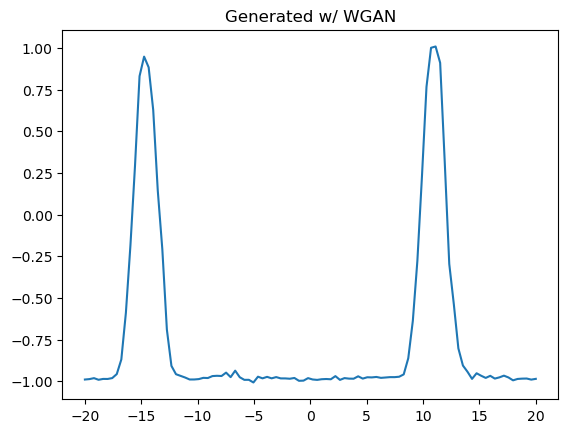

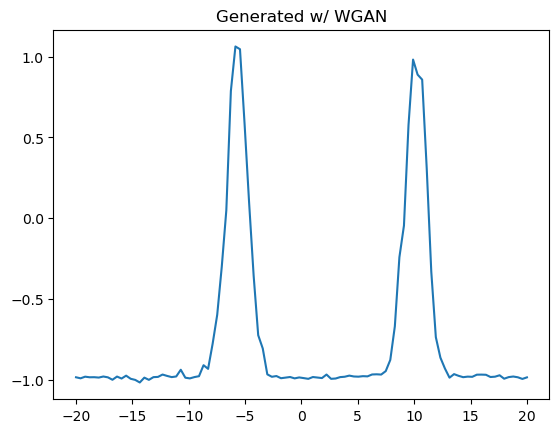

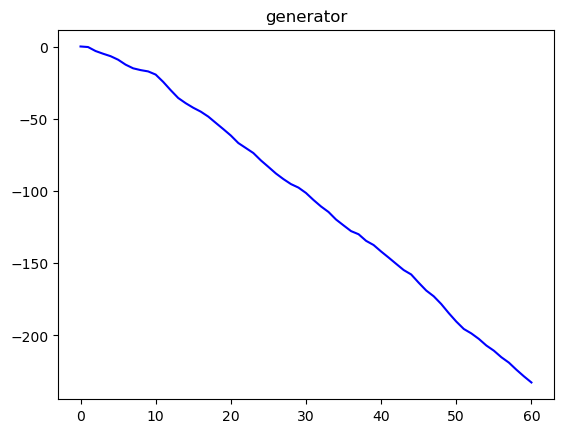

epoch= 61    time= 16.986 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0020    loss_g= -237.90
epoch= 62    time= 17.292 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0076    loss_g= -242.77
epoch= 63    time= 17.626 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00504    loss_g= -248.93
epoch= 64    time= 18.114 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00353    loss_g= -254.14
epoch= 65    time= 18.578 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00498    loss_g= -258.81
epoch= 66    time= 19.039 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0027    loss_g= -262.98
epoch= 67    time= 19.487 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0113    loss_g= -267.66
epoch= 68    time= 19.942 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0026    loss_g= -272.58
epoch= 69    time= 20.413 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00814    loss_g= -280.19
epoch= 70    time= 20.879 min    lr_d= 0.00030

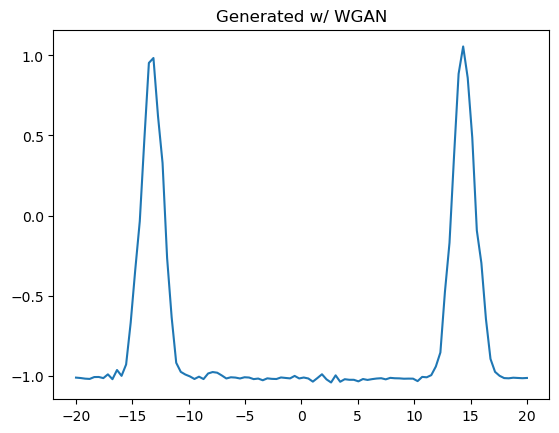

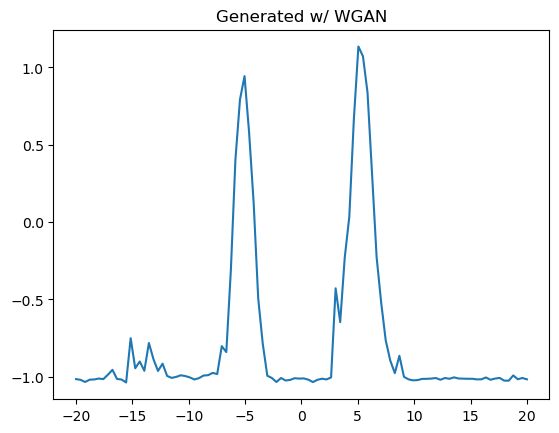

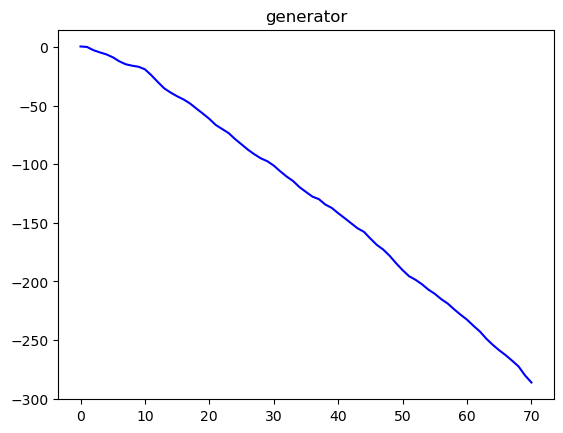

epoch= 71    time= 21.336 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00450    loss_g= -290.95
epoch= 72    time= 21.799 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0088    loss_g= -295.12
epoch= 73    time= 22.298 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0046    loss_g= -300.46
epoch= 74    time= 22.769 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0060    loss_g= -306.09
epoch= 75    time= 23.253 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0009    loss_g= -311.78
epoch= 76    time= 23.769 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0030    loss_g= -317.92
epoch= 77    time= 24.243 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00664    loss_g= -324.94
epoch= 78    time= 24.698 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00173    loss_g= -328.82
epoch= 79    time= 25.200 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00425    loss_g= -336.86
epoch= 80    time= 25.697 min    lr_d= 0.00030

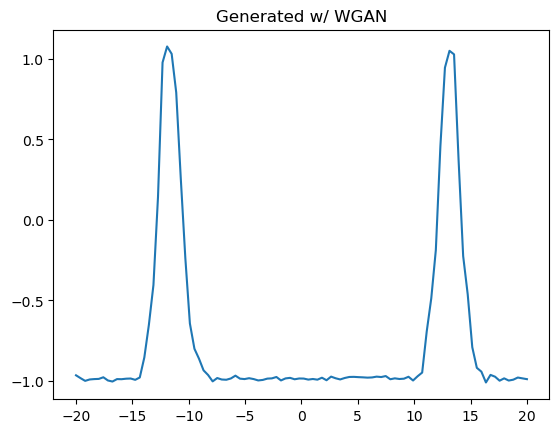

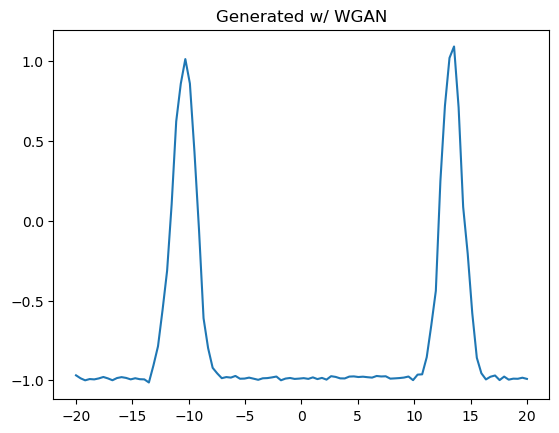

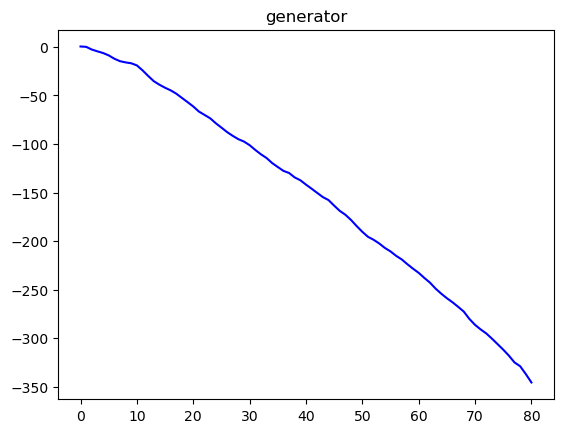

epoch= 81    time= 26.207 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.01739    loss_g= -351.01
epoch= 82    time= 26.718 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00484    loss_g= -355.70
epoch= 83    time= 27.218 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.01207    loss_g= -360.95
epoch= 84    time= 27.736 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00050    loss_g= -367.37
epoch= 85    time= 28.257 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0170    loss_g= -369.08
epoch= 86    time= 28.761 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00241    loss_g= -373.80
epoch= 87    time= 29.246 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00195    loss_g= -378.12
epoch= 88    time= 29.750 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0061    loss_g= -381.92
epoch= 89    time= 30.209 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00143    loss_g= -390.09
epoch= 90    time= 30.698 min    lr_d= 0.00030

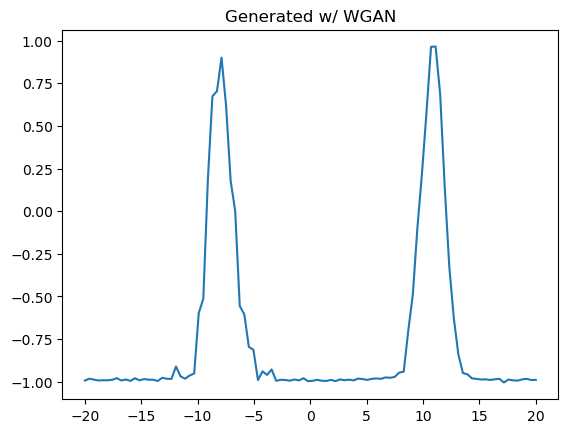

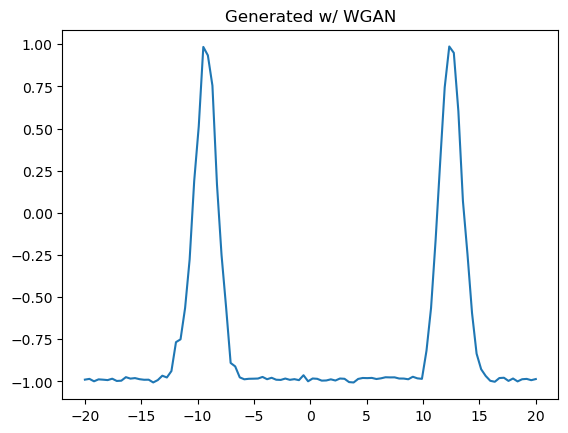

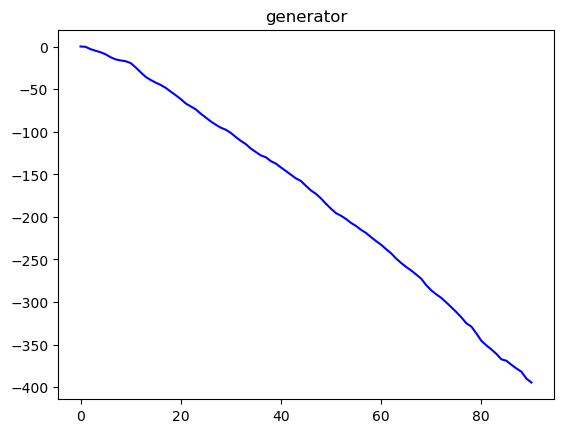

epoch= 91    time= 31.152 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0038    loss_g= -399.79
epoch= 92    time= 31.456 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0134    loss_g= -405.59
epoch= 93    time= 31.769 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00183    loss_g= -410.14
epoch= 94    time= 32.135 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00081    loss_g= -415.88
epoch= 95    time= 32.452 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00659    loss_g= -421.70
epoch= 96    time= 32.784 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00862    loss_g= -428.77
epoch= 97    time= 33.117 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00428    loss_g= -438.92
epoch= 98    time= 33.470 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0054    loss_g= -442.91
epoch= 99    time= 33.807 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00015    loss_g= -447.04


In [8]:
# Training loop
del net
net = WGAN()
net = net.to(device)
_ = display_num_param(net)

# Optimizer
list_param = []
for p in net.generator.parameters():
    list_param.append(p)
for p in net.pe_x.parameters():
    list_param.append(p)
params_gen = nn.ParameterList(list_param)
list_param = []
for p in net.discriminator.parameters():
    list_param.append(p)
for p in net.pe_x.parameters():
    list_param.append(p)
params_dis = nn.ParameterList(list_param)
init_lr = 0.0003
optimizer_g = torch.optim.Adam(params_gen, lr=init_lr, betas=(0.0, 0.9))
optimizer_d = torch.optim.Adam(params_dis, lr=init_lr, betas=(0.0, 0.9))
scheduler_g = optim.lr_scheduler.ReduceLROnPlateau(optimizer_g, mode='min', factor=0.95, patience=1, verbose=True)

print('dz, num_heads, d, num_layers_discriminator, num_layers_generator, drop, dropout_dis, bs : ', \
      dz, num_heads, d, num_layers_discriminator, num_layers_generator, drop, dropout_dis, bs)

# Number of mini-batches per epoch
nb_epochs = 100
run_every_k_steps = 5

list_loss_dis = []
list_loss_gen = []

start = time.time()
for epoch in range(nb_epochs):

    running_loss_d = 0.0
    running_loss_g = 0.0
    num_batches = 0

    net.train()
    
    shuffled_indices = torch.randperm(N)
    for count in range(0,N,bs):

        # discriminator update
        idx_real = shuffled_indices[count : count+bs]
        x_real = train_data[idx_real,:].to(device) # [bs, n]
        z = torch.rand(bs, dz).to(device) # [bs, dz]    
        x_fake = net.forward_gen(z) # [bs, n]
        fake_discr = net.forward_dis(x_fake) # [bs, 1]    
        real_discr = net.forward_dis(x_real) # [bs, 1]
        loss = fake_discr.mean() - real_discr.mean()
        epsilon = torch.FloatTensor(bs, 1).uniform_(0, 1).to(device)
        x_hat = epsilon * x_fake + (1 - epsilon) * x_real
        xhat_discr = net.forward_dis(x_hat)
        grads = torch.autograd.grad(xhat_discr, x_hat, grad_outputs=torch.ones_like(xhat_discr), create_graph=True)[0]
        penalty = ((torch.sqrt((grads ** 2).sum(1)) - 1) ** 2).mean()
        loss = loss + 10 * penalty
        running_loss_d = -loss.detach().cpu().item() 
        optimizer_d.zero_grad()
        loss.backward()
        optimizer_d.step()

        # generator update
        if count % run_every_k_steps == 0:
            z = torch.rand(bs, dz).to(device) # [bs, dz]
            loss = - net.forward_dis(net.forward_gen(z)).mean()
            optimizer_g.zero_grad()
            loss.backward()
            optimizer_g.step()
        running_loss_g += loss.detach().cpu().item() 

        # Compute stats
        num_batches += 1


    # Average stats
    mean_loss_d = running_loss_d/ num_batches
    mean_loss_g = running_loss_g/ num_batches
    if epoch>25:
        scheduler_g.step(mean_loss_g)
        optimizer_d.param_groups[0]['lr'] = optimizer_g.param_groups[0]['lr']
    elapsed = (time.time()-start)/60
    print('epoch=',epoch, '   time=', str(elapsed)[:6],'min', '   lr_d=', '{:.7f}'.format(optimizer_d.param_groups[0]['lr']) , \
          '   lr_g=', '{:.7f}'.format(optimizer_g.param_groups[0]['lr']) , \
          '   loss_d=', str(mean_loss_d)[:7] ,'   loss_g=', str(mean_loss_g)[:7] )
    list_loss_dis.append(mean_loss_d)
    list_loss_gen.append(mean_loss_g)

    # Plot intermediate generated data
    if not epoch%10 and epoch>0:
        plt.plot(x, x_fake[0].detach().cpu()); plt.title("Generated w/ WGAN"); plt.show()
        plt.plot(x, x_fake[1].detach().cpu()); plt.title("Generated w/ WGAN"); plt.show()
        # plt.plot(torch.tensor(list_loss_dis),'b-'); plt.title('discriminator'); plt.show() 
        plt.plot(torch.tensor(list_loss_gen),'b-'); plt.title('generator'); plt.show() 

    # Check lr value
    if optimizer_d.param_groups[0]['lr'] < 10**-5: 
      print("\n lr is equal to min lr -- training stopped\n")
      break




# Q3: Generate new data

Hints: 
- Sample noise `z` from uniform distribution. Use [torch.rand()](https://pytorch.org/docs/stable/generated/torch.rand.html#torch.rand).
- Pass through generator.

batch_x_0 torch.Size([16, 100])


<Figure size 1280x960 with 0 Axes>

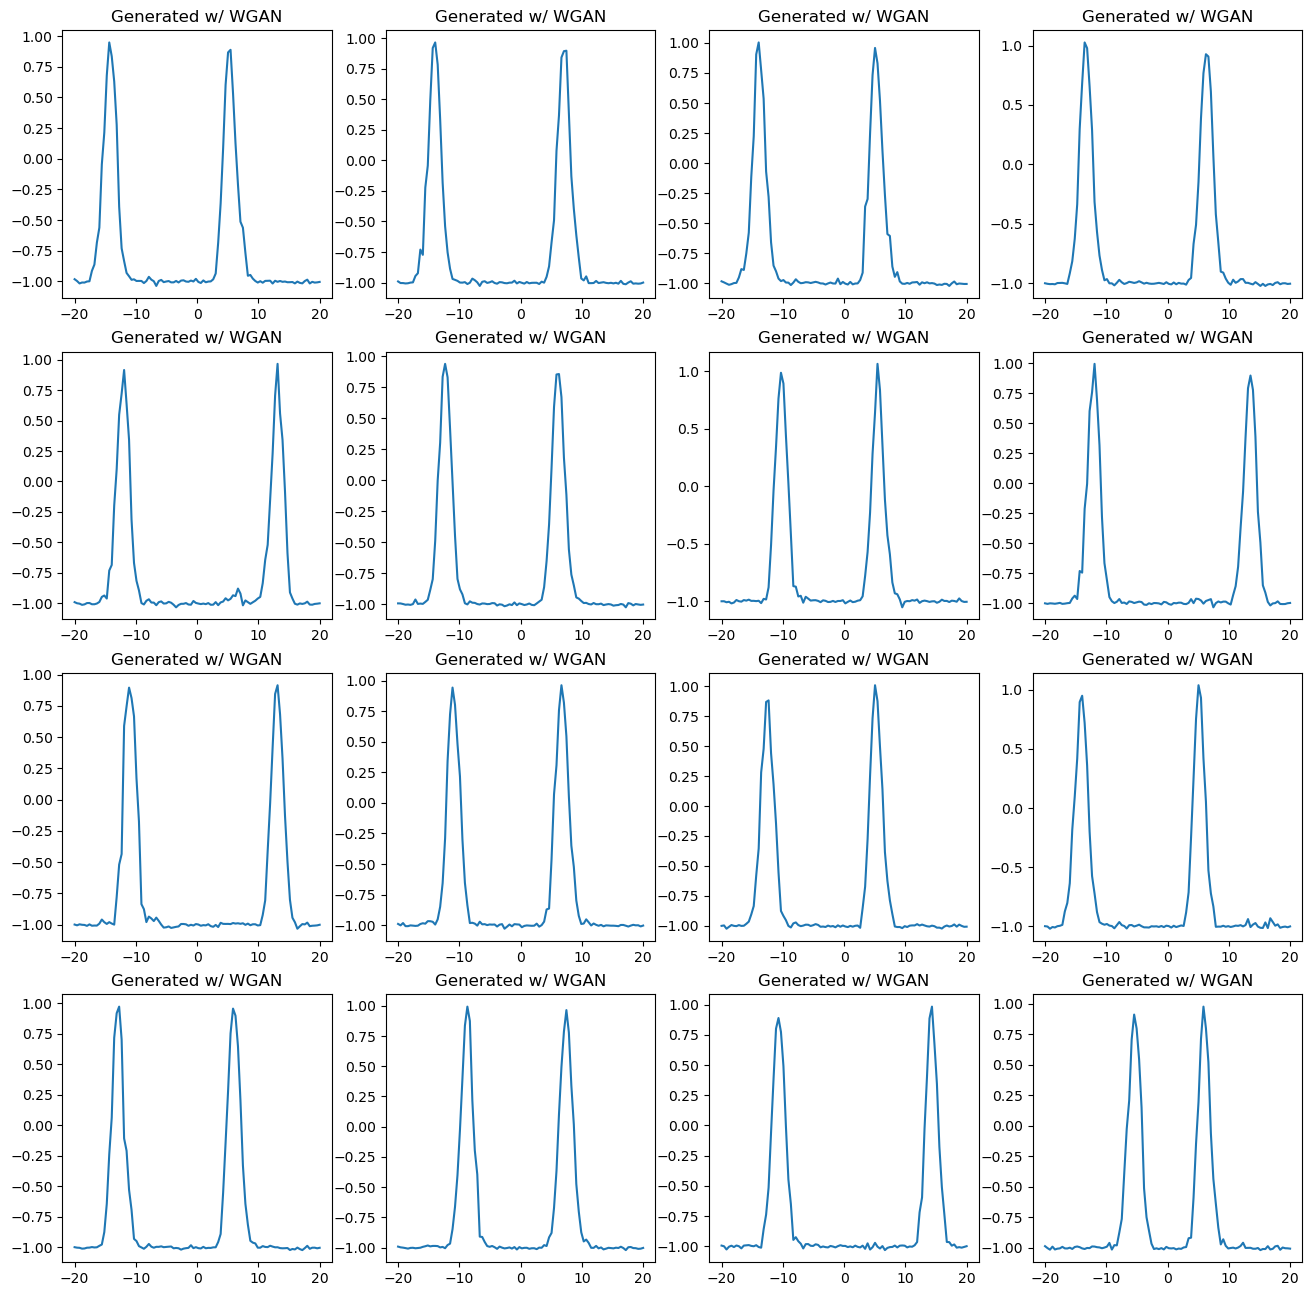

In [9]:
net.eval()
with torch.no_grad():
    num_generated_images = 16
    ###############################################
    # YOUR CODE STARTS
    ###############################################
    z = torch.rand(num_generated_images, dz).to(device) # [bs, dz]
    batch_x_0 = net.forward_gen(z) # [bs, n]
    ###############################################
    # YOUR CODE ENDS
    ###############################################
    print('batch_x_0',batch_x_0.size())
    batch_x_0 = batch_x_0.cpu()

plt.figure(1, dpi=200)
figure, axis = plt.subplots(4, 4)
figure.set_size_inches(16,16)
i,j,cpt=0,0,0; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=1,0,1; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=2,0,2; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=3,0,3; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=0,1+0,4; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=1,1+0,5; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=2,1+0,6; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=3,1+0,7; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=0,2+0,8; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=1,2+0,9; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=2,2+0,10; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=3,2+0,11; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=0,3+0,12; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=1,3+0,13; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=2,3+0,14; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=3,3+0,15; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
plt.show()
